In [1]:
!pip install seaborn

In [72]:
import datetime
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import dask
import dask.array as da
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
# from data_science.augmented_image_sequence_from_npy import AugmentedImageSequenceFromNpy
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_best_practices
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs

In [5]:
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())


True
True


In [17]:
root = '/home/jovyan/work/data/big_earth'
os.listdir(root)

['BigEarthNet-v1.0',
 '.DS_Store',
 'google_automl_cloud_and_shadow_dataset_small.csv',
 'cloud_and_shadow_stats.csv',
 'npy_files',
 'patches_with_cloud_and_shadow.csv',
 'patches_with_seasonal_snow.csv',
 'BigEarthNet-v1.0.tar.gz',
 'model',
 'google_automl_cloud_and_shadow_dataset.csv',
 'metadata',
 'png_image_files',
 'npy_image_files']

In [18]:
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

n_classes = 1
n_epochs = 100
batch_size = 128

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'

early_stopping_patience = 6
use_small_dataset = False
use_random_small_dataset = False

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
log_dir = os.path.join(root, "model/logs")
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"

for directory in [log_dir, model_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [19]:
import json
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

(1, 44)
(1,)


In [73]:
# len(pd.read_csv(root + '/google_automl_cloud_and_shadow_dataset.csv'))

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

1907 253 240
True


In [22]:
if os.path.exists(root + '/cloud_and_shadow_stats.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats.csv')
else:
    stat_list = []
    npy_image_dir = root + "/npy_image_files"
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in train['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['data'] = 'all'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = train[train['has_cloud_and_shadow'] == 0]
    cloud = train[train['has_cloud_and_shadow'] == 1]
    print(len(no_cloud), len(cloud))

    for name, data in [('no_cloud', no_cloud), ('cloud', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['data'] = name
        stat_list.append(stats)    
    
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

In [23]:
stats = all_stats[all_stats['data'] == 'all']

In [24]:
x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

if use_small_dataset:
    size = batch_size
    n_epochs = 3
    x_train = np.concatenate([x_train[:size], x_train[-size:]])
    x_valid = np.concatenate([x_valid[:size], x_valid[-size:]])
    x_test = np.concatenate([x_test[:size], x_test[-size:]])

    y_train = np.concatenate([y_train[:size], y_train[-size:]])
    y_valid = np.concatenate([y_valid[:size], y_valid[-size:]])
    y_test = np.concatenate([y_test[:size], y_test[-size:]])
elif use_random_small_dataset:
    shape = (100, 1)
    x_train = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_train = np.concatenate([np.ones(shape), np.zeros(shape)])

    x_valid = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_valid = np.concatenate([np.ones(shape), np.zeros(shape)])

    y_train = np.random.randint(0, 2, (len(train), 44))
    y_valid = np.random.randint(0, 2, (len(valid), 44))
    y_test = np.random.randint(0, 2, (len(test), 44))
    y_test_labels = test['labels'].values

print(y_train.shape, y_train[0].shape)

(1907, 1) (1,)
(1907, 1) (1,)


In [47]:
# sanity check the generator output
train_batch_generator = SklearnBatchGenerator(x_train, y_train, batch_size, augmentations=None, band_stats=stats)
valid_batch_generator = SklearnBatchGenerator(x_valid, y_valid, batch_size, augmentations=None, band_stats=stats)

train_batch_generator.on_epoch_end()
valid_batch_generator.on_epoch_end()

clf = LogisticRegression()
x, y = train_batch_generator[0]
print(x.shape, x[0].shape, y.shape, y[0].shape)
assert x.shape[-1] == 120 * 120 * 3
clf.fit(x, y)

x, y = valid_batch_generator[0]
pred = clf.predict(x)
print(accuracy_score(pred, y))

(128, 43200) (43200,) (128,) ()
0.578125


/app/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
# check that the pixel values are different and reasonable
num_outputs = 0
for batch_x, batch_y in train_batch_generator.make_one_shot_iterator():
    print(batch_x.mean(), batch_x.std())
    num_outputs += 1
    if num_outputs > 4:
        break

-0.10206464037739119 0.7773150344788853
0.16596680244425602 1.2894328989937456
-0.09893486670253278 0.8420917188229359
0.10821455850320236 1.169033578217063
-0.06045265741658473 0.8739845011385395


In [38]:
# make sure shuffle works
print(train_batch_generator.x[:5])
print('\n\n')
train_batch_generator.on_epoch_end()
print(train_batch_generator.x[:5])

['/home/jovyan/work/npy_image_files/S2B_MSIL2A_20170808T094029_36_82.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20170906T101019_24_38.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20180204T94161_32_32.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20170709T094029_9_84.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20180422T093029_80_79.npy']



['/home/jovyan/work/npy_image_files/S2A_MSIL2A_20170701T093031_74_66.npy'
 '/home/jovyan/work/npy_image_files/S2A_MSIL2A_20170717T113321_80_14.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20171112T114339_60_88.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20170906T101019_37_90.npy'
 '/home/jovyan/work/npy_image_files/S2B_MSIL2A_20170709T094029_41_25.npy']


In [25]:
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

In [48]:
import joblib 

history = list()

classes = np.array([0, 1])
epochs_without_improvement = 0

now = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
experiment_name = f"sgd_classifier_default_2020_1_31"
gcs_model_dir = "model/models"
model_path = os.path.join(model_dir, experiment_name + ".joblib")
model_gcs_path = os.path.join(gcs_model_dir, experiment_name + ".joblib")
model_metadata_path = os.path.join(model_dir, experiment_name + "_metadata.json")
model_metadata_gcs_path = os.path.join(gcs_model_dir, experiment_name + "_metadata.json")

model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "joblib", joblib.load, gcs_model_dir, 
                                                             experiment_name)

if model is not None:
    print('Resuming training at epoch', model_base_metadata['epoch'])
else:
    model = SGDClassifier(loss='log')
    model_base_metadata = {
        'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
        'data_prep': 'normalization_augmentation',
        'experiment_name': experiment_name,
        'experiment_start_time': now,
        'model': SGDClassifier.__name__,
        'random_state': random_seed,
        'epoch': 0
    }
        
# Shuffle the data
train_batch_generator.on_epoch_end()
valid_batch_generator.on_epoch_end()
train_start = time.time()
best_model = None
max_accuracy_valid = None
early_stopping_patience = 15
for epoch in range(int(model_base_metadata['epoch']) + 1, n_epochs):
    start = time.time()
    for batch_x, batch_y in train_batch_generator.make_one_shot_iterator():
        model.partial_fit(batch_x, batch_y, classes=classes)
    
    if epoch % 10 == 0:
        print("training completed in", time.time() - start, "seconds")
    
    start = time.time()
    
    actual_y_train, pred_y_train = train_batch_generator.get_predictions(model)
    actual_y_valid, pred_y_valid = valid_batch_generator.get_predictions(model)
    
    if epoch % 10 == 0:
        print("prediction completed in", time.time() - start, "seconds")

    epoch_time = f"{time.time() - start:.4f}"
    epoch_metrics = {
        'accuracy_train': sklearn.metrics.accuracy_score(actual_y_train, pred_y_train),
        'accuracy_valid': sklearn.metrics.accuracy_score(actual_y_valid, pred_y_valid),        
        "f1_score_train": sklearn.metrics.f1_score(actual_y_train, pred_y_train),
        "f1_score_valid": sklearn.metrics.f1_score(actual_y_valid, pred_y_valid),        
    }
    history.append(epoch_metrics)
    
    print("epoch_num", epoch, "-", epoch_time, "sec -", epoch_metrics['accuracy_valid'])
    
    if max_accuracy_valid is None or epoch_metrics['accuracy_valid'] > max_accuracy_valid:
        max_accuracy_valid = epoch_metrics['accuracy_valid']
        dump(model, model_path)
        with open(model_metadata_path, 'w+') as json_file:
            model_base_metadata.update({
                'epoch': str(epoch),
                'confusion_matrix': numpy_to_json(confusion_matrix(actual_y_valid, pred_y_valid)),
                'precision_recall_curve': sklearn_precision_recall_curve_to_dict(
                    sklearn.metrics.precision_recall_curve(actual_y_valid, pred_y_valid)),
                'history': history,
                'train_time_elapsed': time.time() - train_start
            })
            json.dump(model_base_metadata, json_file)
        
        for filename, gcs_filename in [(model_path, model_gcs_path), (model_metadata_path, model_metadata_gcs_path)]:
            blob = bucket.blob(gcs_filename)
            blob.upload_from_filename(filename)
            
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement == early_stopping_patience:
        print("Ending training due to no improvement")
        break
        
    train_batch_generator.on_epoch_end()
    valid_batch_generator.on_epoch_end()


epoch_num 1 - 3.0593 sec - 0.43873517786561267
epoch_num 2 - 3.1101 sec - 0.4505928853754941
epoch_num 3 - 3.0580 sec - 0.6205533596837944
epoch_num 4 - 3.0930 sec - 0.616600790513834
epoch_num 5 - 3.0623 sec - 0.5928853754940712
epoch_num 6 - 3.1018 sec - 0.6245059288537549
epoch_num 7 - 3.0605 sec - 0.466403162055336
epoch_num 8 - 3.0389 sec - 0.6324110671936759
epoch_num 9 - 3.0618 sec - 0.4426877470355731
training completed in 2.9220175743103027 seconds
prediction completed in 3.05938982963562 seconds
epoch_num 10 - 3.0601 sec - 0.5849802371541502
epoch_num 11 - 3.0370 sec - 0.6126482213438735
epoch_num 12 - 3.0287 sec - 0.5098814229249012
epoch_num 13 - 3.0451 sec - 0.6284584980237155
epoch_num 14 - 3.1046 sec - 0.6561264822134387
epoch_num 15 - 3.0501 sec - 0.5138339920948617
epoch_num 16 - 3.0550 sec - 0.5296442687747036
epoch_num 17 - 3.0520 sec - 0.6482213438735178
epoch_num 18 - 3.0502 sec - 0.44664031620553357
epoch_num 19 - 3.0625 sec - 0.6363636363636364
training completed

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
(128, 120, 120, 3) [-0.40449912 -0.40831072 -0.44344246] (128, 1) [0]
-0.12655985422318042 0.716287449597309 -0.6573675908079565 7.192235301928257
0.07539114904057029 1.0866737281187882 -0.6573675908079565 8.951315044041168
-0.028186219777534743 0.9420864239935469 -0.6573675908079565 7.572212382354717
0.004984226662736775 1.0031857314055865 -0.6573675908079565 8.829071533913487
0.10400321329363685 1.1527845467684517 -0.6573675908079565 8.85020709407575


Image dataset finished 15 batches with 1907 elements in 22.46143341064453


binary_crossentropy - random numbers 0.8313342065284498
binary_crossentropy - cnn with initial weights - actual data 0.7286205


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe849f9b8d0>]],
      dtype=object)

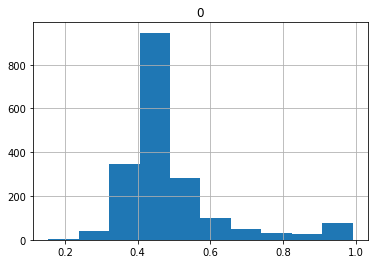

In [26]:
train_dataset = get_image_dataset(x_train, y_train, augmentations=None, band_stats=stats, batch_size=128)

# train_generator = AugmentedImageSequenceFromNpy(x=x_train, y=y_train, batch_size=batch_size,
#                                                 augmentations=None, band_stats=stats)

# imgs, labels = train_generator[0]
# print(imgs.shape, imgs[0][0][0], labels.shape, labels[0])

# num_outputs = 0
# for batch_x, batch_y in train_generator.make_one_shot_iterator():
#     print(batch_x.mean(), batch_x.std(), batch_x.min(), batch_x.max())
#     num_outputs += 1
#     if num_outputs > 4:
#         break

num_outputs = 0
train_iter = train_dataset.make_one_shot_iterator()
imgs, labels = train_iter.get_next()
print(imgs.shape, imgs.numpy()[0][0][0], labels.shape, labels.numpy()[0])

for batch_x, batch_y in train_dataset.make_one_shot_iterator():
    batch_x = batch_x.numpy() 
    print(batch_x.mean(), batch_x.std(), batch_x.min(), batch_x.max())
    num_outputs += 1
    if num_outputs > 4:
        break
start = time.time()
num_batches = 0
num_els = 0
train_dataset = get_image_dataset(x_train, y_train, augmentations=None, band_stats=stats, batch_size=batch_size)
for x, y in train_dataset.make_one_shot_iterator():
    num_batches += 1
    num_els += len(x)    
    continue
print('\n')
print(f'Image dataset finished {num_batches} batches with {num_els} elements in {time.time() - start}')         

from tensorflow.keras.losses import binary_crossentropy
model = basic_cnn_model((120, 120, 3), n_classes)
y_actual, y_pred, y_pred_probs = get_predictions_for_dataset(train_dataset, model)

print('\n')
print('binary_crossentropy - random numbers', 
      binary_crossentropy(np.random.randint(2, size=128), np.random.random_sample(128)).numpy())
print('binary_crossentropy - cnn with initial weights - actual data', 
      binary_crossentropy(y_actual, y_pred_probs).numpy())

pd.DataFrame(y_pred_probs).hist()

In [27]:
def train_keras_model(*, x_train, y_train, x_valid, y_valid, image_augmentations, bucket, model_dir, gcs_model_dir, gcs_log_dir, should_upload_to_gcs,
                      experiment_name, start_model, should_train_from_scratch, lr, n_epochs=100,
                     early_stopping_patience=6, metric_to_monitor='accuracy'):
    model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

    model_and_metadata_filepath = os.path.join(model_dir, experiment_name)
    gcs_model_and_metadata_filepath = os.path.join(gcs_model_dir, experiment_name)
    gcs_log_dir = os.path.join(gcs_log_dir, experiment_name)

    if model is None or should_train_from_scratch:
        now = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M")
        model = start_model
        model_base_metadata = {
            'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
            'data_prep': 'normalization_augmentation',
            'experiment_name': experiment_name,
            'experiment_start_time': now,
            'model': 'keras_cnn',
            'random_state': random_seed,
            # so that initial_epoch is 0
            'epoch': -1
        }        
    else:
        print('Resuming training at epoch', int(model_base_metadata['epoch']) + 1)        

    print(f'len(train): {len(x_train)}')

    if x_valid is not None:
        print(f'len(valid): {len(x_valid)}')
        metric_to_monitor = f'val_{metric_to_monitor}'
        valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=image_augmentations, band_stats=stats, 
                                                  batch_size=batch_size)
    else:
        valid_generator = None
        
    histories = []
    metrics = ['accuracy']
    loss = 'binary_crossentropy'

    optimizer = Adam(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    verbosity = 0
    # Generators
#     train_generator = AugmentedImageSequenceFromNpy(x=x_train, y=y_train, batch_size=batch_size,
#                                                     augmentations=None, band_stats=stats)
#     valid_generator = AugmentedImageSequenceFromNpy(x=x_valid, y=y_valid, batch_size=batch_size,
#                                                     augmentations=None, band_stats=stats)
    train_generator = get_image_dataset(x=x_train, y=y_train, augmentations=image_augmentations, band_stats=stats, 
                                              batch_size=batch_size)
    
    callbacks = [
        EarlyStopping(monitor=metric_to_monitor, patience=early_stopping_patience, verbose=verbosity),
        ReduceLROnPlateau(monitor=metric_to_monitor, factor=0.5, patience=early_stopping_patience, min_lr=1e-6),
        TensorBoard(gcs_log_dir, histogram_freq=1),
    ]
    
    if should_upload_to_gcs:
        callbacks.append(ModelCheckpointGCS(filepath=model_and_metadata_filepath, gcs_filepath=gcs_model_and_metadata_filepath, 
                           gcs_bucket=bucket, model_metadata=model_base_metadata, monitor=metric_to_monitor, 
                           verbose=verbosity))

        
    history = model.fit_generator(train_generator, initial_epoch=int(model_base_metadata['epoch']) + 1,
                                  epochs=n_epochs,
                                  callbacks=callbacks,
                                  validation_data=valid_generator,
                                  shuffle=True, verbose=1)
    
    actual_y_train, pred_y_train, pred_y_train_probs = get_predictions_for_dataset(train_generator, model)
    
    if valid_generator is not None:
        actual_y_valid, pred_y_valid, pred_y_valid_probs = get_predictions_for_dataset(valid_generator, model) 
        
    if should_upload_to_gcs:       
        metadata_filepath = f"{model_and_metadata_filepath}_metadata.json"
        with open(metadata_filepath, 'r') as json_file:
            best_model_metadata = json.load(json_file)

        best_model_metadata.update({
            'accuracy_train': sklearn.metrics.accuracy_score(actual_y_train, pred_y_train),
            'accuracy_valid': sklearn.metrics.accuracy_score(actual_y_valid, pred_y_valid),
            'f1_score_train': sklearn.metrics.f1_score(actual_y_train, pred_y_train),
            'f1_score_valid': sklearn.metrics.f1_score(actual_y_valid, pred_y_valid),
            'confusion_matrix': numpy_to_json(sklearn.metrics.confusion_matrix(actual_y_valid, pred_y_valid)),
            'precision_recall_curve': sklearn_precision_recall_curve_to_dict(
                sklearn.metrics.precision_recall_curve(actual_y_valid, pred_y_valid)),
        })

        with open(metadata_filepath, 'w+') as json_file:
            json.dump(best_model_metadata, json_file)

        blob = bucket.blob(f"{gcs_model_and_metadata_filepath}_metadata.json")
        blob.upload_from_filename(metadata_filepath)
    
    if valid_generator is not None:
        return model, history, actual_y_valid, pred_y_valid, pred_y_valid_probs
    else:
        return model, history, actual_y_train, pred_y_train, pred_y_train_probs        
    
    # Attempt to avoid memory leaks
    del train_generator
    del valid_generator
    gc.collect()
    
# if os.environ.get("SHOULD_PREDICT", "True") == "True":
#     pred_test_labels = predict(model=model, weight_dir=model_path, x=x_test, batch_size=batch_size, n_classes=n_classes)
#     clf_report = classification_report(y_test_labels, pred_test_labels, target_names=classes)
#     print(clf_report)

In [229]:
# Overfit on a small batch

# Include both positive and negative instances    
x_train_small = np.concatenate([x_train[:5], x_train[-5:]])
y_train_small = np.concatenate([y_train[:5], y_train[-5:]])

model = basic_cnn_model((120, 120, 3), n_classes)
history, y_actual, y_pred, y_pred_probs = train_keras_model(
    x_train=x_train_small, y_train=y_train_small, x_valid=None, y_valid=None, image_augmentations=None,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, lr=1e-4,
    should_upload_to_gcs=False,
    n_epochs=30, early_stopping_patience=10, metric_to_monitor='loss')
pd.DataFrame(y_pred_probs).hist()

len(train): 10
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7489 - accuracy: 0.3000
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.5099 - accuracy: 0.9000
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.3779 - accuracy: 0.9000
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.2524 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.1878 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.1290 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.0910 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.0656 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.0450 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.0300 - accuracy: 1.0000
Epoch 11/100
1/1 [======

KeyboardInterrupt: 

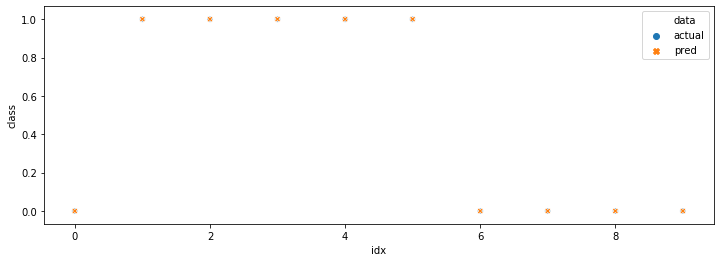

In [71]:
# Check relationship between predicted and actual values
preds = pd.concat([
    pd.DataFrame({'idx': range(len(y_actual)), 'class': y_actual, 'data': ['actual' for _ in range(len(y_actual))]}),
    pd.DataFrame({'idx': range(len(y_actual)), 'class': y_pred, 'data': ['pred' for _ in range(len(y_actual))]})
])

f, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.scatterplot(x=preds['idx'], y=preds['class'], hue=preds['data'], ax=ax, style=preds['data'], 
                markers={'actual': 'o', 'pred': 'X'})

len(train): 1907
len(valid): 253
Epoch 1/200
      1/Unknown - 1s 583ms/step - loss: 0.7405 - accuracy: 0.5938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.871307). Check your callbacks.
15/15 [==============================] - 7s 458ms/step - loss: 1.0987 - accuracy: 0.5343
Epoch 2/200
15/15 [==============================] - 5s 344ms/step - loss: 0.7105 - accuracy: 0.5391
Epoch 3/200
15/15 [==============================] - 5s 341ms/step - loss: 0.6194 - accuracy: 0.6586
Epoch 4/200
15/15 [==============================] - 5s 338ms/step - loss: 0.5579 - accuracy: 0.7158
Epoch 5/200
15/15 [==============================] - 5s 339ms/step - loss: 0.4938 - accuracy: 0.7777
Epoch 6/200
15/15 [==============================] - 5s 341ms/step - loss: 0.4405 - accuracy: 0.8112
Epoch 7/200
15/15 [==============================] - 5s 361ms/step - loss: 0.4086 - accuracy: 0.8411
Epoch 8/200
15/15 [==============================] - 5s 334ms/step - loss: 0.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4059669c88>]],
      dtype=object)

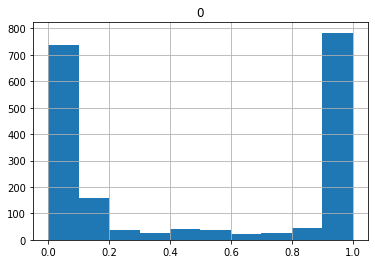

In [74]:
# Overfit on all training data
model = basic_cnn_model((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_2020_1_31"
history, y_actual, y_pred, y_pred_probs = train_keras_model(
    x_train=x_train, y_train=y_train, x_valid=None, y_valid=None, image_augmentations=None,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, lr=3e-4,
    should_upload_to_gcs=False,
    n_epochs=200, early_stopping_patience=10)
pd.DataFrame(y_pred_probs).hist()

In [93]:
valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=None, band_stats=stats, 
                                                  batch_size=batch_size)
actual_y_valid, pred_y_valid, pred_y_valid_probs = get_predictions_for_dataset(valid_generator, model) 
print('val_loss', binary_crossentropy(actual_y_valid, pred_y_valid_probs).numpy())
print('val_accuracy', accuracy_score(actual_y_valid, pred_y_valid))

val_loss 0.6236074
val_accuracy 0.8814229249011858


len(train): 1907
len(valid): 253
Epoch 1/100
      1/Unknown - 1s 664ms/step - loss: 0.9860 - accuracy: 0.4609WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.859568). Check your callbacks.
15/15 [==============================] - 11s 705ms/step - loss: 0.6831 - accuracy: 0.7221 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 8s 550ms/step - loss: 0.3816 - accuracy: 0.8511 - val_loss: 1.4853 - val_accuracy: 0.4862
Epoch 3/100
15/15 [==============================] - 8s 529ms/step - loss: 0.2954 - accuracy: 0.8820 - val_loss: 1.1966 - val_accuracy: 0.4901
Epoch 4/100
15/15 [==============================] - 8s 538ms/step - loss: 0.2492 - accuracy: 0.9025 - val_loss: 0.7682 - val_accuracy: 0.5138
Epoch 5/100
15/15 [==============================] - 8s 546ms/step - loss: 0.2245 - accuracy: 0.9245 - val_loss: 0.6368 - val_accuracy: 0.6443
Epoch 6/100
15/15 [==============================] - 8s 530m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ba1473048>]],
      dtype=object)

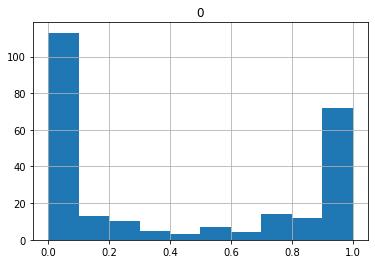

In [252]:
# Start basic_cnn_model_with_regularization by adding batch normalization and validation set 
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_with_regularization_2020_1_31"
history, y_actual, y_pred, y_pred_probs = train_keras_model(
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=None,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=30)
pd.DataFrame(y_pred_probs).hist()

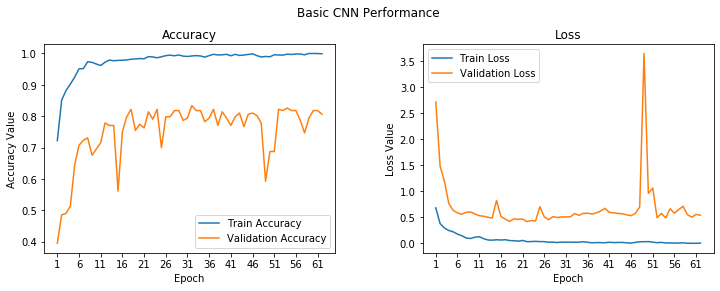

In [254]:
graph_model_history(history.history)

In [212]:
augmentations_train = Compose([
    Flip(p=0.5),
    Rotate(limit=(0, 360), p=0.5),
])

(128, 120, 120, 3) [-0.40659964 -0.49913651 -0.45767791] (128, 1) [1]
0.027591167818225883 1.0636115827563706 -0.6573675908079566 8.942850332525591
0.04680030539431623 1.02632356859598 -0.6579388221636933 6.005213286171044
0.13599491041413556 1.1543325794180535 -0.6573675908079566 9.34567442851301
-0.0003182379773971013 1.0192809968907472 -0.6573675908079566 7.556368073331842
-0.05500515870664811 0.9123794748910226 -0.6573675908079566 7.843233498797221


Image dataset finished 15 batches with 1907 elements in 3.298898696899414


binary_crossentropy - random numbers 1.065257351339798
binary_crossentropy - cnn with initial weights - actual data 0.8630689


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f40500aa518>]],
      dtype=object)

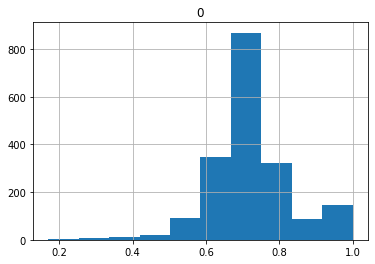

In [218]:
train_dataset = get_image_dataset(x_train, y_train, augmentations=augmentations_train, band_stats=stats, batch_size=128)

num_outputs = 0
train_iter = train_dataset.make_one_shot_iterator()
imgs, labels = train_iter.get_next()
print(imgs.shape, imgs.numpy()[0][0][0], labels.shape, labels.numpy()[0])

for batch_x, batch_y in train_dataset.make_one_shot_iterator():
    batch_x = batch_x.numpy() 
    print(batch_x.mean(), batch_x.std(), batch_x.min(), batch_x.max())
    num_outputs += 1
    if num_outputs > 4:
        break
start = time.time()
num_batches = 0
num_els = 0
train_dataset = get_image_dataset(x_train, y_train, augmentations=augmentations_train, band_stats=stats, batch_size=batch_size)
for x, y in train_dataset.make_one_shot_iterator():
    num_batches += 1
    num_els += len(x)    
    continue
print('\n')
print(f'Image dataset finished {num_batches} batches with {num_els} elements in {time.time() - start}')         

from tensorflow.keras.losses import binary_crossentropy
model = basic_cnn_model((120, 120, 3), n_classes)
y_actual, y_pred, y_pred_probs = get_predictions_for_dataset(train_dataset, model)

print('\n')
print('binary_crossentropy - random numbers', 
      binary_crossentropy(np.random.randint(2, size=128), np.random.random_sample(128)).numpy())
print('binary_crossentropy - cnn with initial weights - actual data', 
      binary_crossentropy(y_actual, y_pred_probs).numpy())

pd.DataFrame(y_pred_probs).hist()

Resuming training at epoch 41
len(train): 1907
len(valid): 253


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bb3936ba8>]],
      dtype=object)

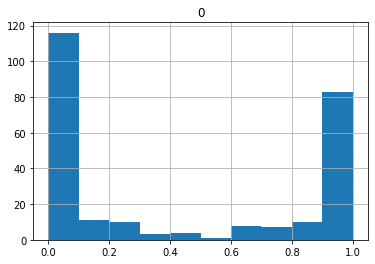

In [309]:
# Add image augmentation
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_with_regularization_and_aug_2020_1_31"

model, history, y_actual, y_pred, y_pred_probs = train_keras_model(
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=2, early_stopping_patience=1)
pd.DataFrame(y_pred_probs).hist()

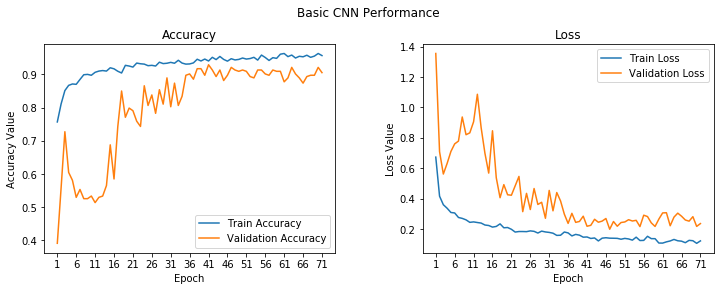

In [225]:
graph_model_history(history.history)

In [ ]:
# Hyperparameter optimization 

model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_with_regularization_and_aug_2020_1_31"

model, history, y_actual, y_pred, y_pred_probs = train_keras_model(
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=2, early_stopping_patience=1)
pd.DataFrame(y_pred_probs).hist()

In [233]:
arr = np.load(npy_files[0])
r = json.dumps({'img': arr.tolist()})
arr_2 = np.array(json.loads(r)['img']).reshape(120, 120, 3).astype(np.int16)
(arr == arr_2).all()

In [200]:
precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])

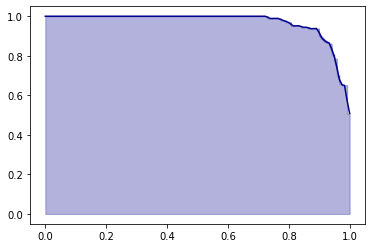

In [177]:
ax = sns.lineplot(x=recall, y=precision, color='darkblue')
ax.fill_betweean(recall,precision, color="darkblue", alpha=0.3)

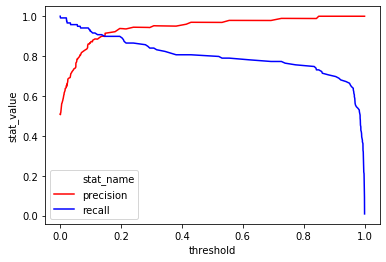

In [206]:
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)